<a href="https://colab.research.google.com/github/maurofama99/ann_challenge/blob/main/ANN_challenge1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/My Drive/ANN/data2

/gdrive/My Drive/ANN/data2


In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
# Load the dataset to be used for classification
!unzip training_dataset_homework1.zip

Archive:  training_dataset_homework1.zip
   creating: training_data_final/Species1/
  inflating: training_data_final/Species1/00000.jpg  
  inflating: training_data_final/Species1/00001.jpg  
  inflating: training_data_final/Species1/00002.jpg  
  inflating: training_data_final/Species1/00003.jpg  
  inflating: training_data_final/Species1/00004.jpg  
  inflating: training_data_final/Species1/00005.jpg  
  inflating: training_data_final/Species1/00006.jpg  
  inflating: training_data_final/Species1/00007.jpg  
  inflating: training_data_final/Species1/00008.jpg  
  inflating: training_data_final/Species1/00009.jpg  
  inflating: training_data_final/Species1/00010.jpg  
  inflating: training_data_final/Species1/00011.jpg  
  inflating: training_data_final/Species1/00012.jpg  
  inflating: training_data_final/Species1/00013.jpg  
  inflating: training_data_final/Species1/00014.jpg  
  inflating: training_data_final/Species1/00015.jpg  
  inflating: training_data_final/Species1/00016.jpg 

In [7]:
# Dataset folders 
dataset_dir = 'training_data_final'


In [8]:
#get the number of img of each species
import fnmatch

count = [0,0,0,0,0,0,0,0]
labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

for i in range(len(labels)):
  dir_path = os.path.join(dataset_dir, labels[i])
  print(dir_path)
  count[i] = len(fnmatch.filter(os.listdir(dir_path), '*.*'))
  print('The number of img of', labels[i], 'is: ', count[i])

cumsum = np.cumsum(count)
print('Total amount of img is: ', cumsum[len(cumsum)-1] )

training_data_final/Species1
The number of img of Species1 is:  186
training_data_final/Species2
The number of img of Species2 is:  532
training_data_final/Species3
The number of img of Species3 is:  515
training_data_final/Species4
The number of img of Species4 is:  511
training_data_final/Species5
The number of img of Species5 is:  531
training_data_final/Species6
The number of img of Species6 is:  222
training_data_final/Species7
The number of img of Species7 is:  537
training_data_final/Species8
The number of img of Species8 is:  508
Total amount of img is:  3542


In [9]:
"Given functions"
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm


def plot_confusionMatrix(test_labels, test_predicted):
  print("val labels: ", test_labels)
  print("labels predicted: ", test_predicted)
  cm = confusion_matrix(test_labels, test_predicted, labels=[0,1,2,3,4,5,6,7])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot()
  plt.show()
  return 


In [10]:
def testModel( valid_gen, model):

  # d. Predit test labels
  test_predicted = model.predict(valid_gen)
  test_predicted = np.argmax(test_predicted, axis=-1)
  

  # e. plot confusion matrix
  plot_confusionMatrix(valid_gen.classes, test_predicted)

  # f. display classification results
  print(classification_report(valid_gen.classes, test_predicted, target_names=labels))

In [11]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2) 

aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255,
                                        validation_split=0.2)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=32,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset="training")

valid_gen = data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed,
                                               subset="validation")

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [12]:
input_shape = (96, 96, 3)
epochs = 200

In [13]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [14]:
for layer in supernet.layers:
    layer.trainable = False

In [13]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg16_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg16_layer)

    layer1 = tfkl.Dense(units=1028, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.3, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [14]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [17]:
# Build model and visualize it
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1028)              4738052   
                                                                 
 dropout (Dropout)           (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 512)               526848    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0     

In [18]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_1')

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 29s 247ms/step - loss: 15.7007 - accuracy: 0.2394 - val_loss: 1.5117 - val_accuracy: 0.4037
Epoch 2/200
89/89 [==============================] - 21s 233ms/step - loss: 13.1571 - accuracy: 0.3709 - val_loss: 1.3896 - val_accuracy: 0.4929
Epoch 3/200
89/89 [==============================] - 21s 239ms/step - loss: 12.4187 - accuracy: 0.4051 - val_loss: 1.3442 - val_accuracy: 0.4731
Epoch 4/200
89/89 [==============================] - 24s 271ms/step - loss: 12.0338 - accuracy: 0.4228 - val_loss: 1.2657 - val_accuracy: 0.5269
Epoch 5/200
89/89 [==============================] - 22s 249ms/step - loss: 11.6501 - accuracy: 0.4482 - val_loss: 1.2742 - val_accuracy: 0.4972
Epoch 6/200
89/89 [==============================] - 22s 245ms/step - loss: 11.3920 - accuracy: 0.4577 - val_loss: 1.3005 - val_accuracy: 0.4759
Epoch 7/200
89/89 [==============================] - 24s 268ms/step - loss: 11.3312 - accuracy: 0.4728 - val_loss: 1.2639 - val_ac

In [19]:
# Save best epoch model
model.save("savedModels/CNN_VGG16_1")

706/706 [==============================] - 4s 6ms/step
val labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5

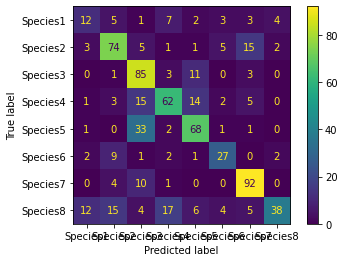

              precision    recall  f1-score   support

    Species1       0.39      0.32      0.35        37
    Species2       0.67      0.70      0.68       106
    Species3       0.55      0.83      0.66       103
    Species4       0.65      0.61      0.63       102
    Species5       0.66      0.64      0.65       106
    Species6       0.64      0.61      0.63        44
    Species7       0.74      0.86      0.80       107
    Species8       0.83      0.38      0.52       101

    accuracy                           0.65       706
   macro avg       0.64      0.62      0.61       706
weighted avg       0.67      0.65      0.64       706



In [20]:
testModel(valid_gen, model)

In [21]:
m = tfk.models.load_model("savedModels/CNN_VGG16_1")
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1028)              4738052   
                                                                 
 dropout (Dropout)           (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 512)               526848    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0     

In [22]:
m.get_layer('vgg16').trainable = True

In [23]:
m.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1028)              4738052   
                                                                 
 dropout (Dropout)           (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 512)               526848    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0     

In [24]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16_FineTuning')

# Train the model
history = m.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 26s 255ms/step - loss: 15.8586 - accuracy: 0.2560 - val_loss: 1.5618 - val_accuracy: 0.3853
Epoch 2/200
89/89 [==============================] - 23s 253ms/step - loss: 12.1132 - accuracy: 0.4041 - val_loss: 1.4404 - val_accuracy: 0.4547
Epoch 3/200
89/89 [==============================] - 22s 249ms/step - loss: 11.5343 - accuracy: 0.4598 - val_loss: 1.1961 - val_accuracy: 0.5071
Epoch 4/200
89/89 [==============================] - 21s 240ms/step - loss: 10.5852 - accuracy: 0.5049 - val_loss: 1.1982 - val_accuracy: 0.5212
Epoch 5/200
89/89 [==============================] - 22s 248ms/step - loss: 10.1245 - accuracy: 0.5264 - val_loss: 1.2279 - val_accuracy: 0.5057
Epoch 6/200
89/89 [==============================] - 22s 251ms/step - loss: 9.6402 - accuracy: 0.5755 - val_loss: 1.2768 - val_accuracy: 0.5297
Epoch 7/200
89/89 [==============================] - 22s 245ms/step - loss: 8.7699 - accuracy: 0.6164 - val_loss: 1.2936 - val_accu

In [25]:
# Save best epoch model
m.save("savedModels/CNN_VGG16_FineTuning")

706/706 [==============================] - 4s 5ms/step
val labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5

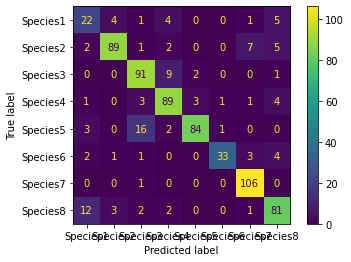

              precision    recall  f1-score   support

    Species1       0.52      0.59      0.56        37
    Species2       0.92      0.84      0.88       106
    Species3       0.78      0.88      0.83       103
    Species4       0.82      0.87      0.85       102
    Species5       0.94      0.79      0.86       106
    Species6       0.94      0.75      0.84        44
    Species7       0.89      0.99      0.94       107
    Species8       0.81      0.80      0.81       101

    accuracy                           0.84       706
   macro avg       0.83      0.82      0.82       706
weighted avg       0.85      0.84      0.84       706



In [26]:
testModel(valid_gen, m)

#Now add weights

In [ ]:
# Build model (for NO augmentation training)
model1 = build_model(input_shape)

In [ ]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_1')

# Train the model
history = model1.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = noaug_callbacks,
).history

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_NoAug_Best_Weight")

#Try with VGG16
first not trainable

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

In [ ]:
for layer in supernet.layers:
    layer.trainable = False

In [ ]:
def pre_build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    vgg16_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(vgg16_layer)

    layer1 = tfkl.Dense(units=512, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.3, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
vgg16 = pre_build_model(input_shape)
vgg16.summary()

In [ ]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_VGG16')

# Train the model
history = vgg16.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_VGG16_Best")

#another pre processed ANN

In [17]:
supernet = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

83683744/83683744 [==============================] - 4s 0us/step


In [18]:
for layer in supernet.layers:
    layer.trainable = False

In [19]:
xCeption = build_model(input_shape)
xCeption.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 1028)              18949124  
                                                                 
 dropout (Dropout)           (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 512)               526848    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0     

In [20]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption')

# Train the model
history = xCeption.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
75/89 [========================>.....] - ETA: 3:54 - loss: 15.8340 - accuracy: 0.2492

KeyboardInterrupt: ignored

In [31]:
# Save best epoch model
xCeption.save("savedModels/CNN_XCeption")

706/706 [==============================] - 15s 18ms/step
val labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5

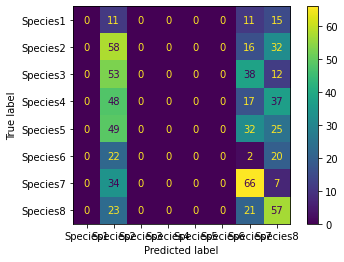

              precision    recall  f1-score   support

    Species1       0.00      0.00      0.00        37
    Species2       0.19      0.55      0.29       106
    Species3       0.00      0.00      0.00       103
    Species4       0.00      0.00      0.00       102
    Species5       0.00      0.00      0.00       106
    Species6       0.00      0.00      0.00        44
    Species7       0.33      0.62      0.43       107
    Species8       0.28      0.56      0.37       101

    accuracy                           0.26       706
   macro avg       0.10      0.22      0.14       706
weighted avg       0.12      0.26      0.16       706



In [32]:
testModel(valid_gen, xCeption)

In [1]:
xc = tfk.models.load_model("savedModels/CNN_XCeption")
xc.summary()

NameError: ignored

In [35]:
xc.get_layer('xception').trainable = True

In [36]:
xc.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
xc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b3 (Function  (None, 3, 3, 1536)       12930622  
 al)                                                             
                                                                 
 Flatten (Flatten)           (None, 13824)             0         
                                                                 
 dense_1 (Dense)             (None, 1028)              14212100  
                                                                 
 dropout_2 (Dropout)         (None, 1028)              0         
                                                                 
 Classifier (Dense)          (None, 512)               526848    
                                                             

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_EffNet_FineTuning')

# Train the model
history = xc.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

Epoch 1/200
89/89 [==============================] - 60s 462ms/step - loss: 18.2085 - accuracy: 0.2415 - val_loss: 1.8768 - val_accuracy: 0.2861
Epoch 2/200
89/89 [==============================] - 38s 425ms/step - loss: 14.9158 - accuracy: 0.3255 - val_loss: 1.6725 - val_accuracy: 0.3399
Epoch 3/200
89/89 [==============================] - 39s 440ms/step - loss: 13.2820 - accuracy: 0.4009 - val_loss: 1.7367 - val_accuracy: 0.3215
Epoch 4/200
89/89 [==============================] - 38s 427ms/step - loss: 12.9077 - accuracy: 0.4030 - val_loss: 1.6094 - val_accuracy: 0.3442
Epoch 5/200
89/89 [==============================] - 37s 412ms/step - loss: 12.5919 - accuracy: 0.4175 - val_loss: 1.5099 - val_accuracy: 0.4306
Epoch 6/200
89/89 [==============================] - 37s 422ms/step - loss: 11.6965 - accuracy: 0.4609 - val_loss: 1.5540 - val_accuracy: 0.3810
Epoch 7/200
89/89 [==============================] - 36s 408ms/step - loss: 11.4660 - accuracy: 0.4686 - val_loss: 1.4945 - val_ac

In [ ]:
# Save best epoch model
xc.save("savedModels/CNN_EffNet_FineTuning")

In [ ]:
testModel(valid_gen, xc)